In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('total_field_data.csv')

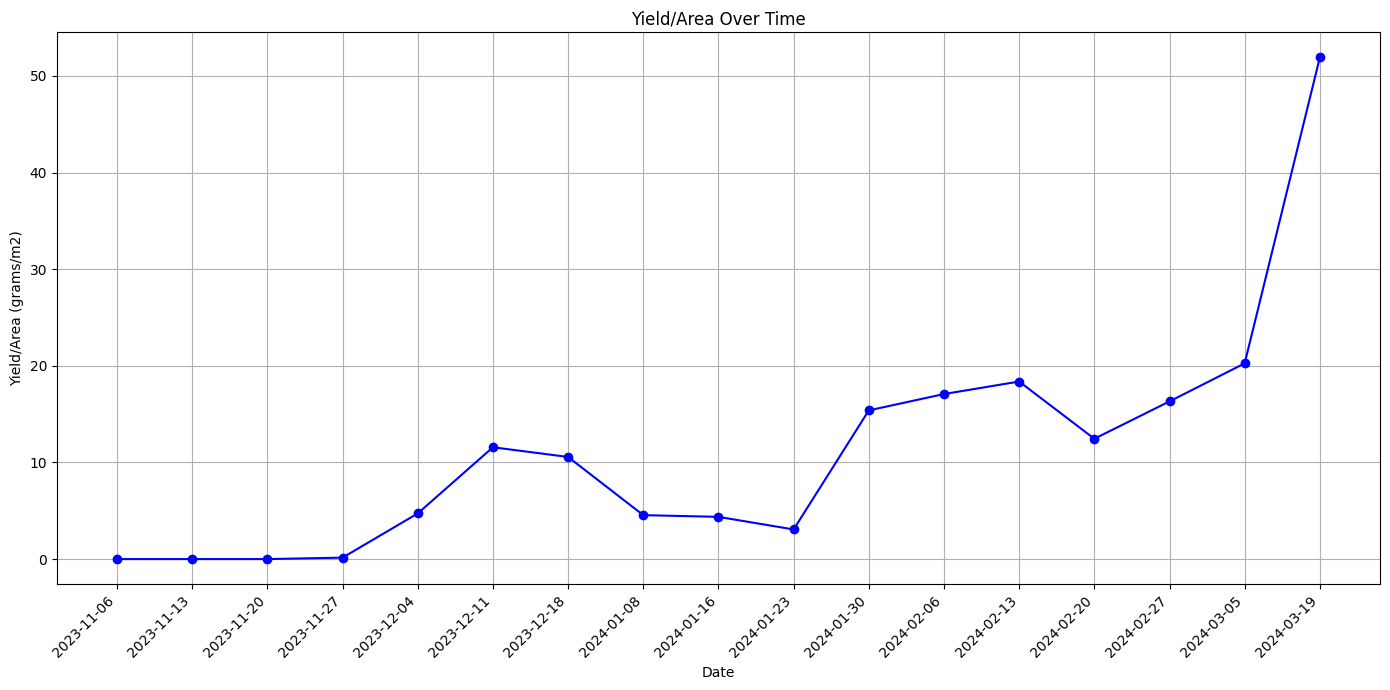

In [3]:
# Convert 'DATES' to a readable format for tick labels
df['DATES'] = pd.to_datetime(df['DATES'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# Plotting 'Y/A' against the row number
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Y/A'], marker='o', linestyle='-', color='blue')
plt.title('Yield/Area Over Time')
plt.xlabel('Date')
plt.ylabel('Yield/Area (grams/m2)')

# Setting up the dates as x-axis tick labels
plt.xticks(df.index, df['DATES'], rotation=45, ha="right")  # Rotate for better readability

# Optional: For sparse tick labels, you can display every nth label
# n = 5  # Example: Show every 5th label
# for index, label in enumerate(plt.gca().get_xticklabels()):
#     if index % n != 0:
#         label.set_visible(False)

plt.tight_layout()
plt.grid(True)
plt.show()

In [13]:
columns = ['FL', 'G', 'W', 'P', 'R','canopy','Y/A']
df_train = df[columns].astype(float)

In [14]:
df_train

,FL,G,W,P,R,canopy,Y/A
0,112.0,0.0,0.0,0.0,0.0,87343940.0,0.000000
1,334.0,369.0,0.0,0.0,0.0,87343940.0,0.000000
2,548.0,843.0,17.0,0.0,0.0,87343940.0,0.000000
3,411.0,1053.0,386.0,36.0,10.0,87343940.0,0.149246
4,209.0,1049.0,558.0,118.0,214.0,87343940.0,4.723950
5,145.0,1250.0,630.0,228.0,495.0,81329128.0,11.570865
6,212.0,1101.0,556.0,211.0,586.0,85043448.0,10.567242
7,866.0,1274.0,181.0,152.0,333.0,71738874.0,4.546585
8,944.0,1472.0,397.0,118.0,222.0,135282969.0,4.369221
9,940.0,1229.0,543.0,173.0,156.0,100144908.0,3.066025


In [15]:
# Normalize the data
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(df_train)

In [16]:
scaled_data_test = scaled_data[12:15]

In [17]:
scaled_data_train = scaled_data[:12]

In [18]:
# Prepare sequences
trainX, trainY = [], []
past_no_of_days, future_no_of_days = 1, 1

In [19]:
for i in range(past_no_of_days, len(scaled_data_train) - future_no_of_days + 1):
    trainX.append(scaled_data_train[i - past_no_of_days:i])
    trainY.append(scaled_data_train[i + future_no_of_days - 1:i + future_no_of_days, 6])

trainX, trainY = torch.FloatTensor(trainX), torch.FloatTensor(trainY)

In [20]:
trainX[0:5]

tensor([[[-1.0768, -1.5129, -1.1645, -1.1733, -1.0444, -0.2529, -0.9129]],

        [[-0.5783, -1.0234, -1.1645, -1.1733, -1.0444, -0.2529, -0.9129]],

        [[-0.0976, -0.3947, -1.1177, -1.1733, -1.0444, -0.2529, -0.9129]],

        [[-0.4053, -0.1161, -0.1020, -0.8385, -1.0138, -0.2529, -0.9007]],

        [[-0.8590, -0.1214,  0.3714, -0.0760, -0.3895, -0.2529, -0.5286]]])

In [21]:
trainY

tensor([[-0.9129],
        [-0.9129],
        [-0.9007],
        [-0.5286],
        [ 0.0285],
        [-0.0532],
        [-0.5430],
        [-0.5574],
        [-0.6634],
        [ 0.3388],
        [ 0.4765]])

In [22]:
# DataLoader
batch_size = 16
train_data = TensorDataset(trainX, trainY)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)


In [23]:

# Model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [29]:
input_dim = len(columns)
hidden_dim = 16
num_layers = 3
output_dim = 1

In [30]:
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers)

In [31]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
losses = []

In [33]:
# Training Loop
num_epochs = 200
model.train()

GRUModel(
  (gru): GRU(7, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [34]:
# Modify the training loop to record the loss
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.3909788429737091
Epoch 2, Loss: 0.38454997539520264
Epoch 3, Loss: 0.3782489597797394
Epoch 4, Loss: 0.3720746338367462
Epoch 5, Loss: 0.36602532863616943
Epoch 6, Loss: 0.3600980341434479
Epoch 7, Loss: 0.3542880713939667
Epoch 8, Loss: 0.34858936071395874
Epoch 9, Loss: 0.34299519658088684
Epoch 10, Loss: 0.33749881386756897
Epoch 11, Loss: 0.3320936858654022
Epoch 12, Loss: 0.32677358388900757
Epoch 13, Loss: 0.3215325176715851
Epoch 14, Loss: 0.31636473536491394
Epoch 15, Loss: 0.31126436591148376
Epoch 16, Loss: 0.30622589588165283
Epoch 17, Loss: 0.3012436330318451
Epoch 18, Loss: 0.296312153339386
Epoch 19, Loss: 0.29142633080482483
Epoch 20, Loss: 0.2865810692310333
Epoch 21, Loss: 0.28177177906036377
Epoch 22, Loss: 0.2769942879676819
Epoch 23, Loss: 0.2722449004650116
Epoch 24, Loss: 0.26752033829689026
Epoch 25, Loss: 0.26281797885894775
Epoch 26, Loss: 0.25813546776771545
Epoch 27, Loss: 0.2534712851047516
Epoch 28, Loss: 0.24882401525974274
Epoch 29, Loss:

In [35]:

# Assuming 'model' is your model instance
torch.save(model.state_dict(), 'DAM_GRU_multi-variate_forecasting_model2_3layers_200_epochs.pth')

## LOADING SAVED MODEL

In [37]:
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load('DAM_GRU_multi-variate_forecasting_model2_3layers_200_epochs.pth'))
model.eval()  # Set the model to evaluation mode


GRUModel(
  (gru): GRU(7, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

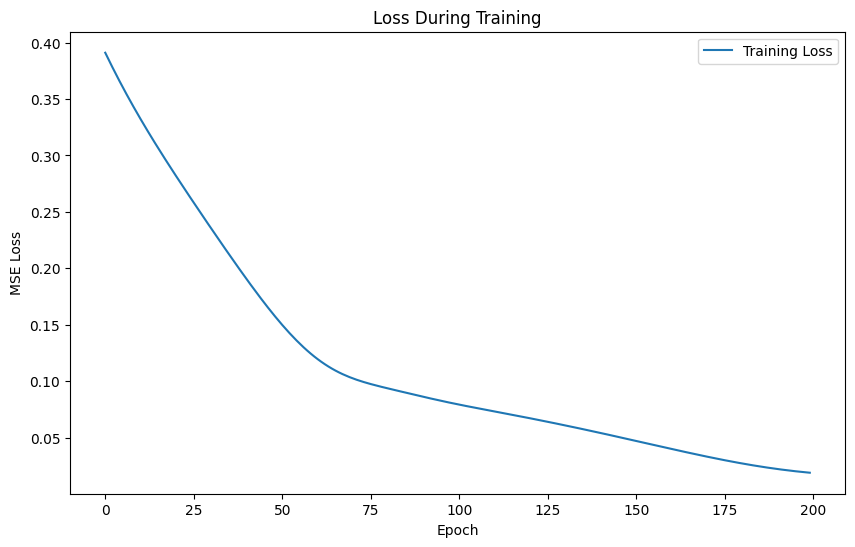

In [38]:
# 2. Visualization of Loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [39]:
trainX.shape

torch.Size([11, 1, 7])

In [40]:
testX = torch.FloatTensor(scaled_data_test[0]).unsqueeze(0).unsqueeze(0)

In [41]:
testX.shape

torch.Size([1, 1, 7])

In [42]:
testX

tensor([[[1.2140, 1.3603, 2.2486, 0.3052, 2.0126, 0.9782, 0.5818]]])

In [43]:
# Now, use the model to predict
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference mode, gradients not computed
    test_preds = model(testX)

In [44]:
# Convert predictions back to numpy array if necessary
test_preds = test_preds.numpy()

In [45]:
test_preds

array([[0.76326007]], dtype=float32)

# Train Predictions

In [46]:
predictions_train = []

In [47]:
for i in range(12):
    train_predictions_X = torch.FloatTensor(scaled_data_train[i]).unsqueeze(0).unsqueeze(0)
    # Now, use the model to predict
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Inference mode, gradients not computed
        train_preds = model(train_predictions_X)
    
    # Convert predictions back to numpy array if necessary
    train_preds = train_preds.numpy()
    predictions_train.append(train_preds)


In [48]:
inverse_scaled_train_preds = []

In [49]:
for i in range(12):
    copies = np.repeat(predictions_train[i],scaled_data.shape[1],axis=-1)
    train_y_pred_future = standard_scaler.inverse_transform(copies)[0][scaled_data.shape[1]-1]
    inverse_scaled_train_preds.append(max(0,train_y_pred_future))

In [50]:
inverse_scaled_train_preds

[0,
 0,
 0.47596553,
 6.2250533,
 9.019981,
 8.965253,
 8.558777,
 4.8382993,
 3.6795125,
 14.429469,
 15.847286,
 9.0373]

## Test predictions

In [51]:
predictions_test=[]

In [52]:
for i in range(3):
    testX = torch.FloatTensor(scaled_data_test[i]).unsqueeze(0).unsqueeze(0)
    # Now, use the model to predict
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Inference mode, gradients not computed
        test_preds = model(testX)
    
    # Convert predictions back to numpy array if necessary
    test_preds = test_preds.numpy()
    predictions_test.append(test_preds)


In [53]:
predictions_test[0].shape

(1, 1)

In [54]:
inverse_scaled_test_preds = []

In [55]:
for i in range(3):
    copies = np.repeat(predictions_test[i],scaled_data.shape[1],axis=-1)
    test_y_pred_future = standard_scaler.inverse_transform(copies)[0][scaled_data.shape[1]-1]
    inverse_scaled_test_preds.append(test_y_pred_future)

In [56]:
inverse_scaled_test_preds

[20.60305, 16.840633, 16.241545]

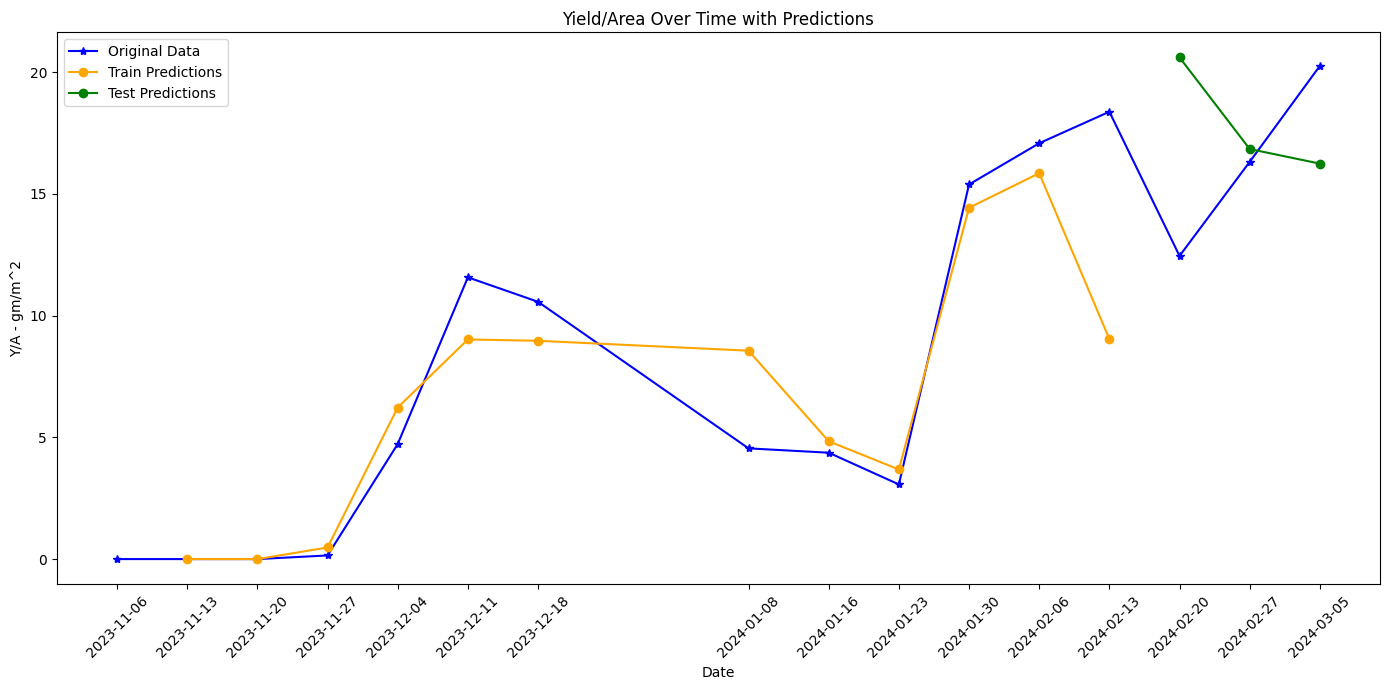

In [57]:
# Load your dataset
df = pd.read_csv('total_field_data.csv')  # Update with your file path
# Ensure 'DATES' is in the correct datetime format for plotting
df['DATES'] = pd.to_datetime(df['DATES'], format='%Y%m%d')

# Assuming your predictions are in these lists
train_predictions = inverse_scaled_train_preds
test_predictions = inverse_scaled_test_preds

# Adjusting the index for train predictions
train_pred_index = df.index[1:13]  # Assuming the first prediction corresponds to the second data point

# Adjusting the index for test predictions
test_pred_index = df.index[13:16]  # Assuming you have 3 test predictions starting from index 13

# Plotting the original Y/A data
plt.figure(figsize=(14, 7))
plt.plot(df['DATES'][:16], df['Y/A'][:16], label='Original Data', color='blue',marker='*')

# Plotting the train predictions
plt.plot(df['DATES'].iloc[train_pred_index], train_predictions, label='Train Predictions', color='orange', marker='o')

# Plotting the test predictions
plt.plot(df['DATES'].iloc[test_pred_index], test_predictions, label='Test Predictions', color='green', marker='o')

# Making the plot readable
plt.title('Yield/Area Over Time with Predictions')
plt.xlabel('Date')
plt.ylabel('Y/A - gm/m^2')
plt.xticks(df['DATES'][:16],rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
original_yield_area = df['Y/A'][:16]

In [59]:
original_yield_area

0      0.000000
1      0.000000
2      0.000000
3      0.149246
4      4.723950
5     11.570865
6     10.567242
7      4.546585
8      4.369221
9      3.066025
10    15.385281
11    17.077813
12    18.372357
13    12.450116
14    16.314281
15    20.255232
Name: Y/A, dtype: float64

In [60]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Train MSE

In [61]:
# Calculate MSE using values from index 1 to 12 in the original_yield_area list
train_predictions_mse = mean_squared_error(original_yield_area[1:13], inverse_scaled_train_preds)
train_predictions_mse

9.808214773564531

In [62]:
# Calculate MSE using values from index 1 to 12 in the original_yield_area list
train_predictions_mae = mean_absolute_error(original_yield_area[1:13], inverse_scaled_train_preds)
train_predictions_mae

1.8830707586302544

# Test MSE

In [63]:
# Calculate MSE using values from index 1 to 12 in the original_yield_area list
test_predictions_mse = mean_squared_error(original_yield_area[13:], inverse_scaled_test_preds)
test_predictions_mse

27.619020774868236

In [64]:
# Calculate MSE using values from index 1 to 12 in the original_yield_area list
train_predictions_mae = mean_absolute_error(original_yield_area[13:], inverse_scaled_test_preds)
train_predictions_mae

4.230991090172778